# CESNET Sampling and EDA

In [ ]:
import pandas as pd
import numpy as np

### Load QUICaid Benign Data

In [ ]:
quicaid_df = pd.read_csv('benign.csv')
quicaid_df.dropna(inplace=True)
quicaid_df

### Load CESNET Data

In [ ]:
# columns = pd.read_csv('cesnet_dataset.csv', nrows=0).columns
# cesnet_df = pd.DataFrame(columns=list(columns))

# for chunk in pd.read_csv('cesnet_dataset.csv', chunksize=100000):
#     cesnet_df = pd.concat([cesnet_df, chunk], ignore_index=True)
#     if len(cesnet_df) == 200000: break

# cesnet_df

In [ ]:
# cesnet_df.to_csv('reduced_cesnet.csv', index=None)

In [ ]:
cesnet_df = pd.read_csv('reduced_cesnet.csv')
cesnet_df.dropna(inplace=True)
cesnet_df

### EDA

In [ ]:
quicaid_df.describe()

In [ ]:
cesnet_df.describe()

Common columns: ['total_bytes', 'ave_fwd_bytes', 'min_rev_bytes', 'var_fwd_iat', 'max_bytes', 'min_fwd_iat', 'var_rev_bytes', 'std_iat', 'max_fwd_iat', 'rev_pkts', 'std_rev_bytes', 'max_fwd_bytes', 'ave_iat', 'std_fwd_bytes', 'ratio', 'min_bytes', 'flow_byte_rate', 'quic_ver', 'var_bytes', 'min_rev_iat', 'max_iat', 'fwd_bytes', 'var_rev_iat', 'dst_port', 'flow_pkt_rate', 'dur', 'label', 'std_bytes', 'std_rev_iat', 'fwd_dur', 'std_fwd_iat', 'var_fwd_bytes', 'var_iat', 'rev_dur', 'max_rev_iat', 'ave_bytes', 'ave_rev_iat', 'dst_asn', 'min_iat', 'ave_rev_bytes', 'ave_fwd_iat', 'rev_bytes', 'fwd_pkts', 'max_rev_bytes', 'min_fwd_bytes', 'total_pkts']

Dataset 1 summary:
        total_bytes  ave_fwd_bytes  min_rev_bytes   var_fwd_iat  \
count  164720.00000  164720.000000  164720.000000  1.647200e+05   
mean    31430.45312      59.595099     978.326736  9.316219e-01   
std      5650.01728      93.183972     458.027598  3.627466e+01   
min         0.00000       0.000000       0.000000  0.000000

C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


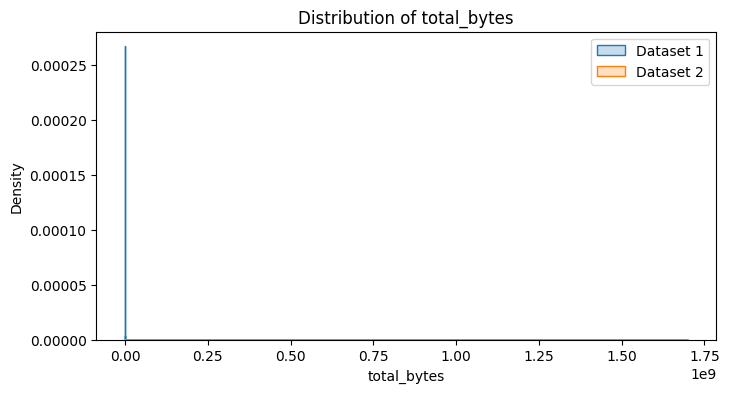

total_bytes - KS Test: Stat=0.728, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


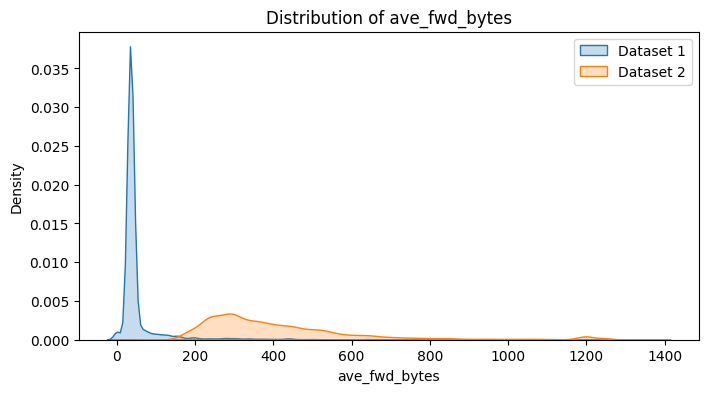

ave_fwd_bytes - KS Test: Stat=0.937, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


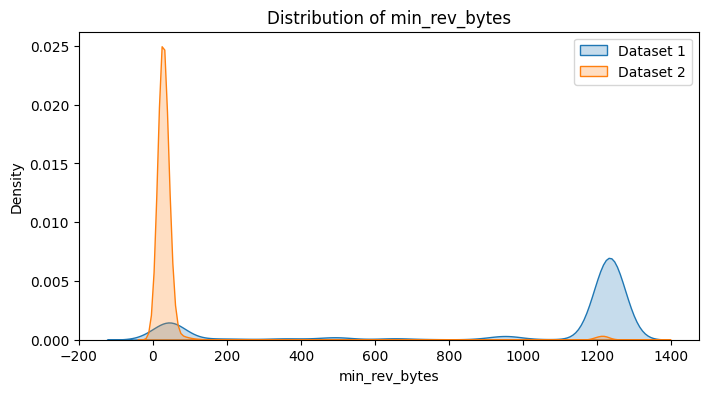

min_rev_bytes - KS Test: Stat=0.921, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


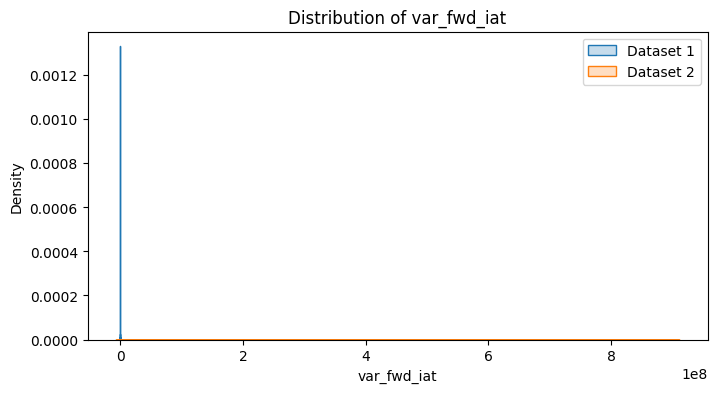

var_fwd_iat - KS Test: Stat=0.958, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


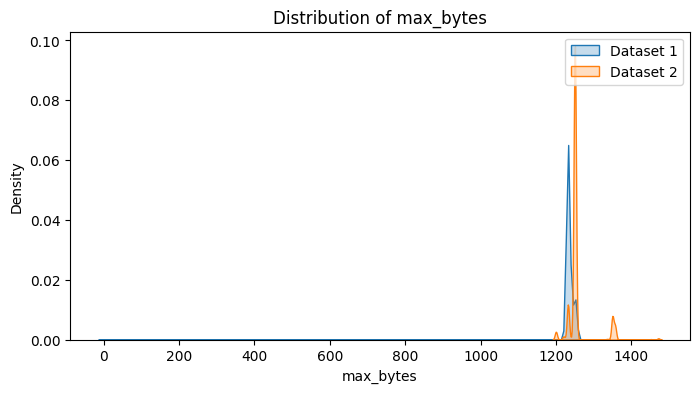

max_bytes - KS Test: Stat=0.705, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


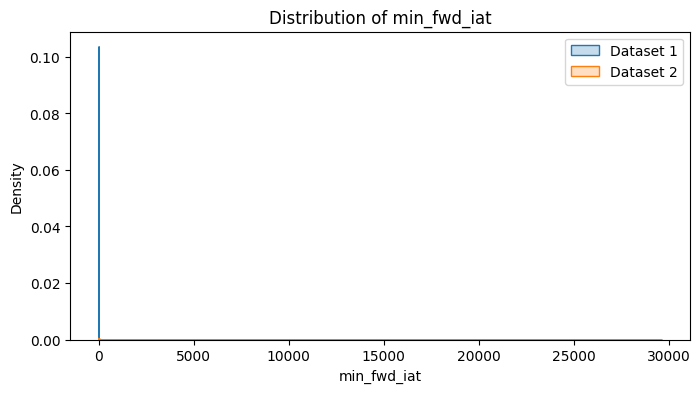

min_fwd_iat - KS Test: Stat=0.907, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


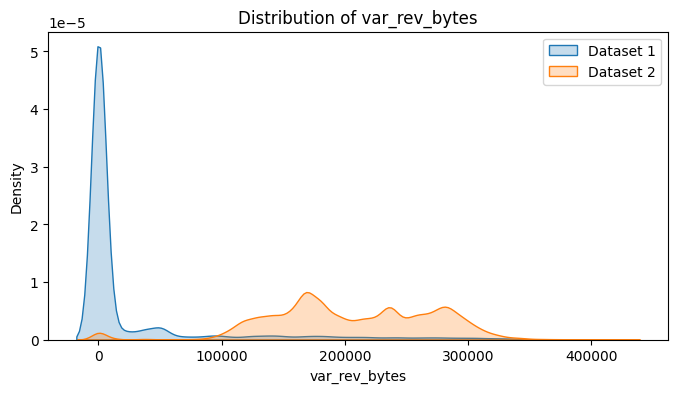

var_rev_bytes - KS Test: Stat=0.863, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


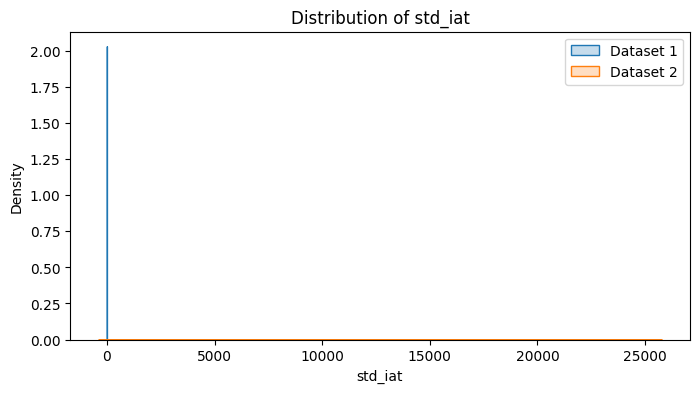

std_iat - KS Test: Stat=0.978, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


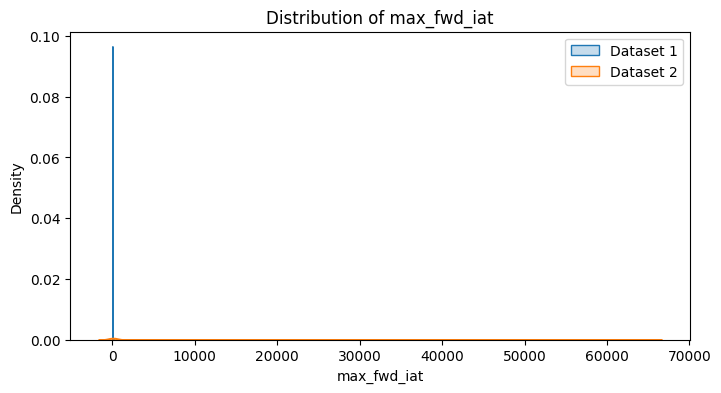

max_fwd_iat - KS Test: Stat=0.962, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


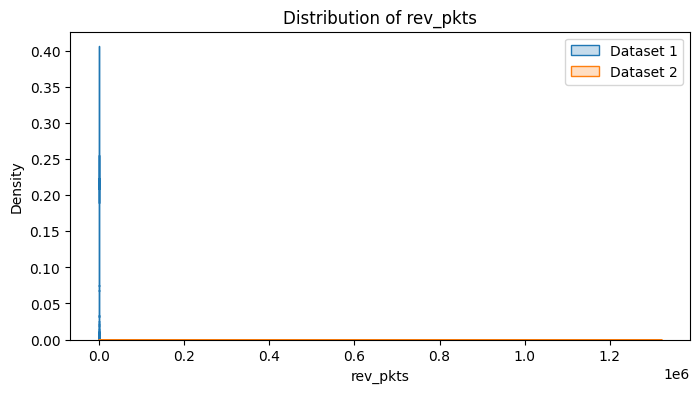

rev_pkts - KS Test: Stat=0.686, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


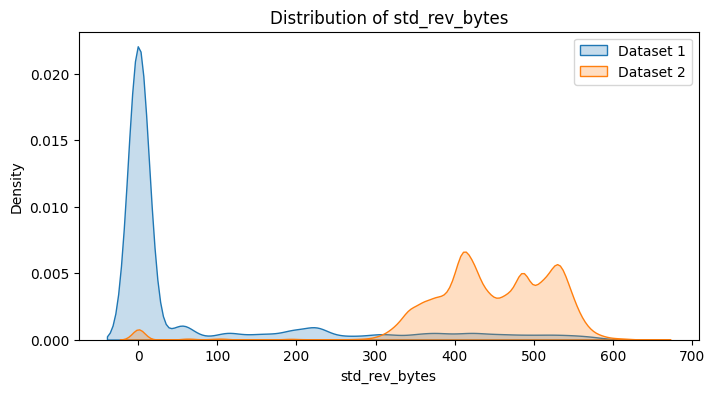

std_rev_bytes - KS Test: Stat=0.863, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


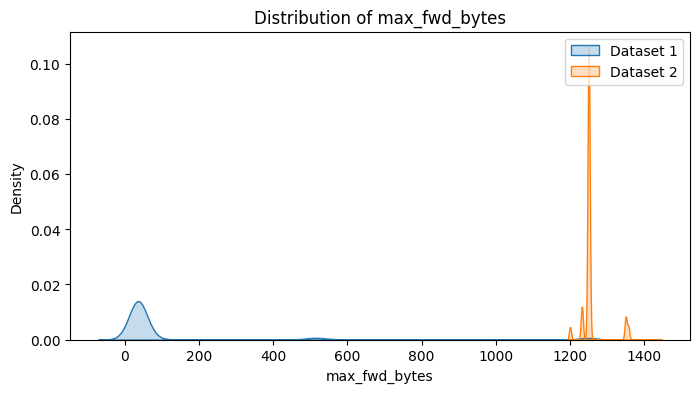

max_fwd_bytes - KS Test: Stat=0.962, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


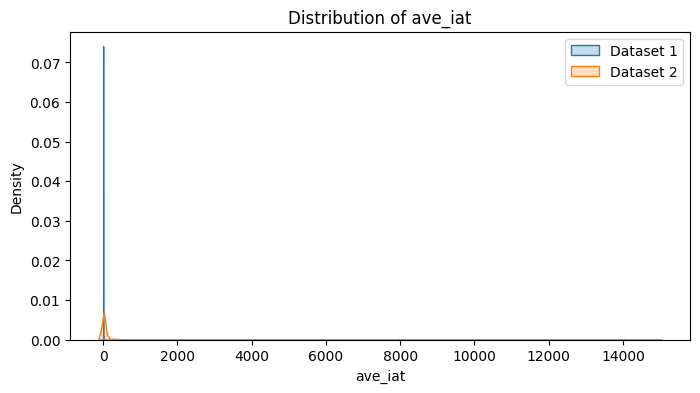

ave_iat - KS Test: Stat=0.983, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


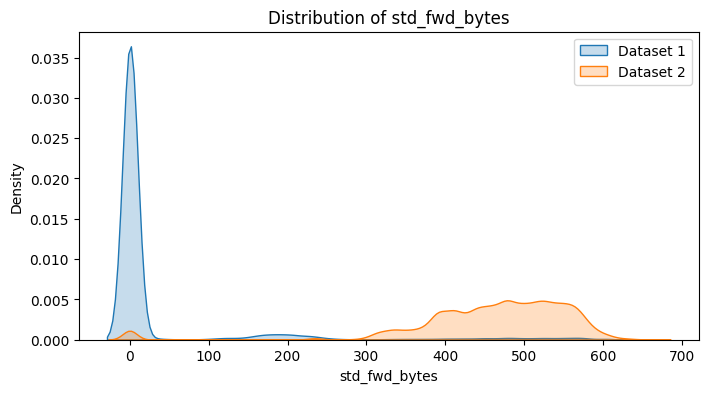

std_fwd_bytes - KS Test: Stat=0.927, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


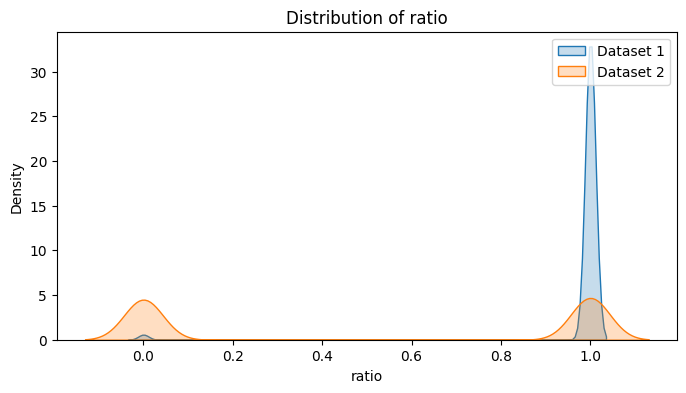

ratio - KS Test: Stat=0.473, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


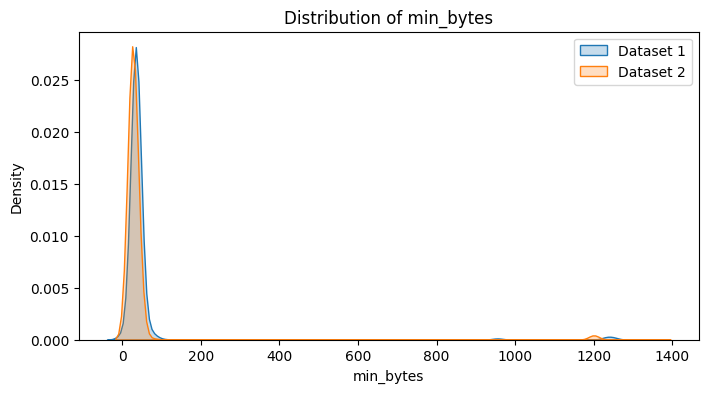

min_bytes - KS Test: Stat=0.801, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


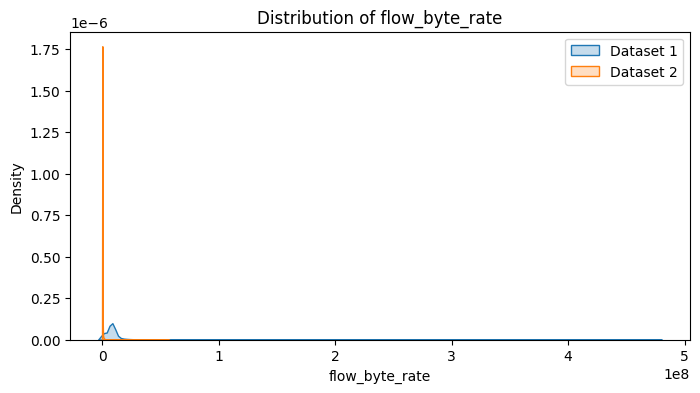

flow_byte_rate - KS Test: Stat=0.888, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


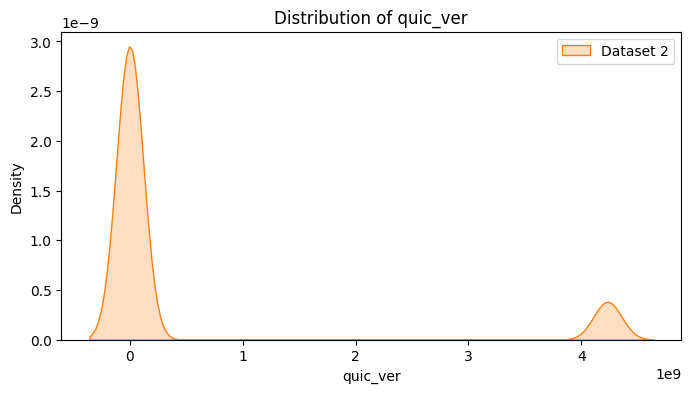

quic_ver - KS Test: Stat=0.118, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


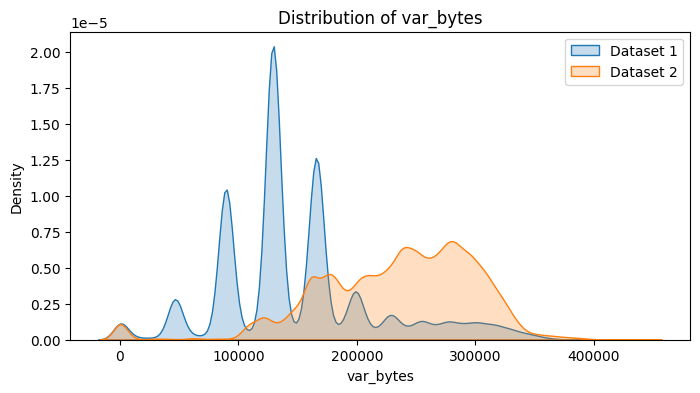

var_bytes - KS Test: Stat=0.613, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


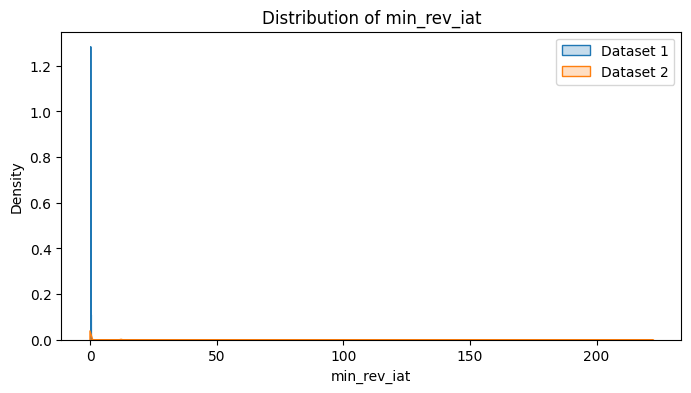

min_rev_iat - KS Test: Stat=0.987, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


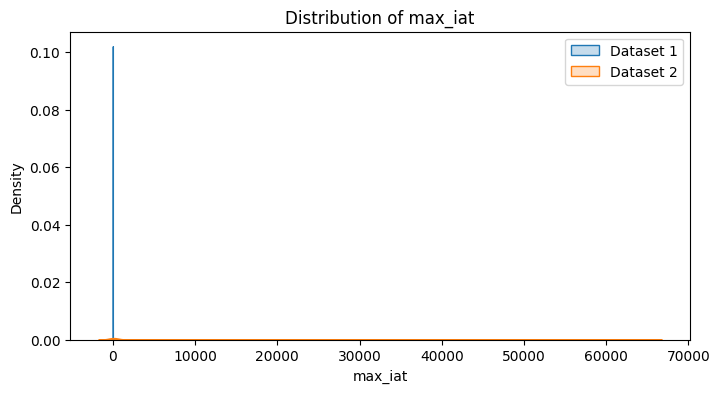

max_iat - KS Test: Stat=0.989, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


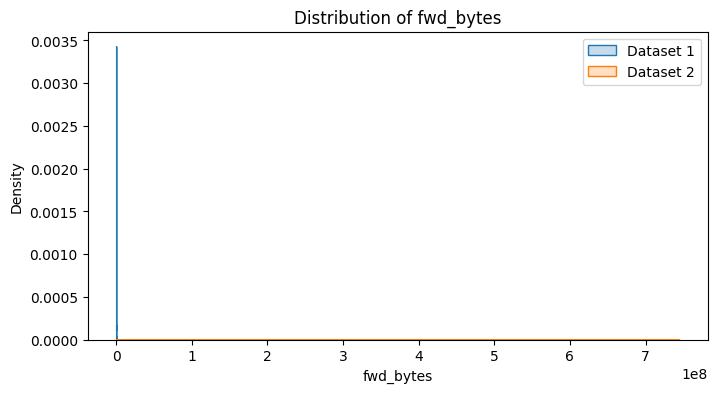

fwd_bytes - KS Test: Stat=0.948, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


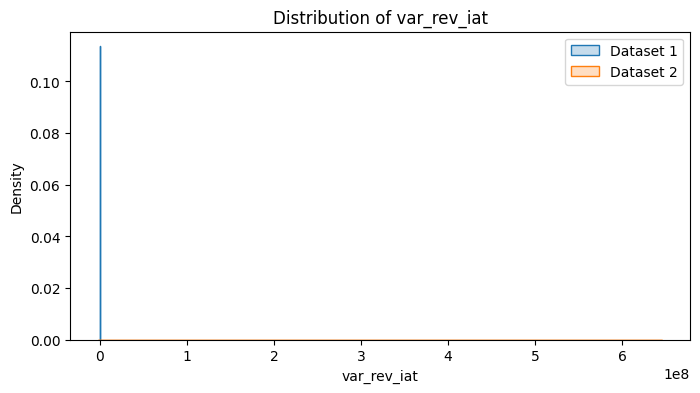

C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable t

var_rev_iat - KS Test: Stat=0.984, P-Value=0.000


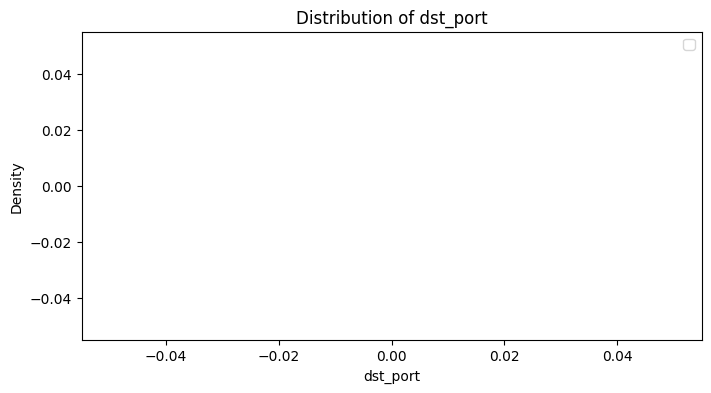

dst_port - KS Test: Stat=0.000, P-Value=1.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


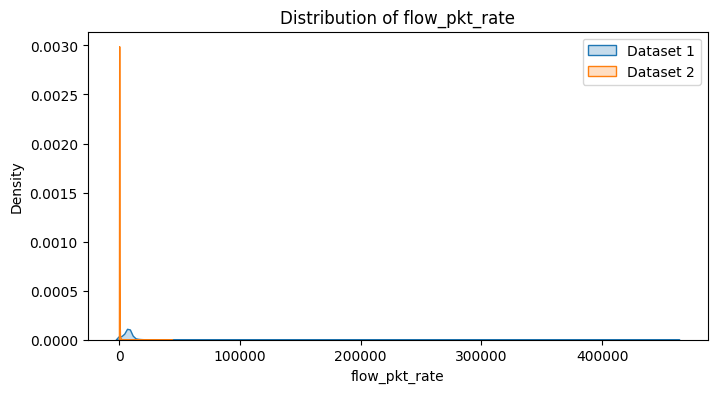

flow_pkt_rate - KS Test: Stat=0.884, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


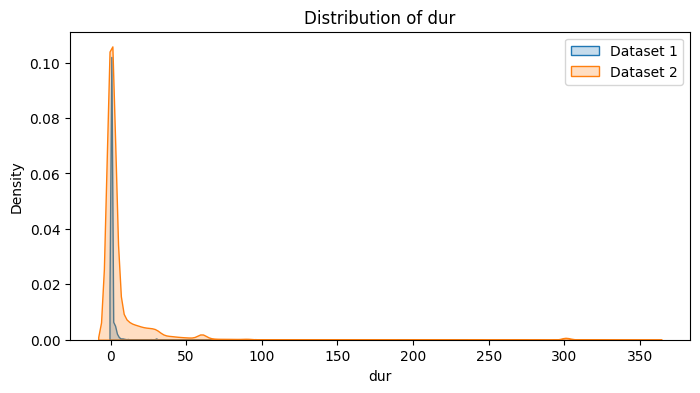

C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable t

dur - KS Test: Stat=0.877, P-Value=0.000


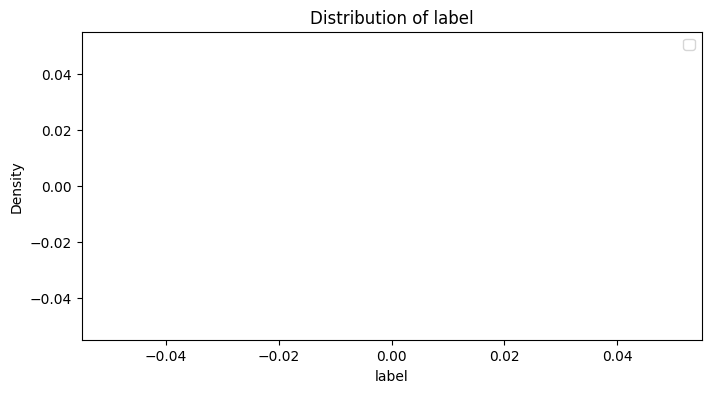

label - KS Test: Stat=0.000, P-Value=1.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


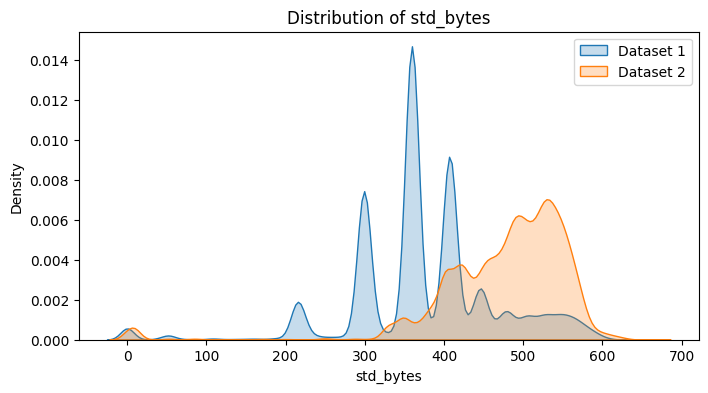

std_bytes - KS Test: Stat=0.613, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


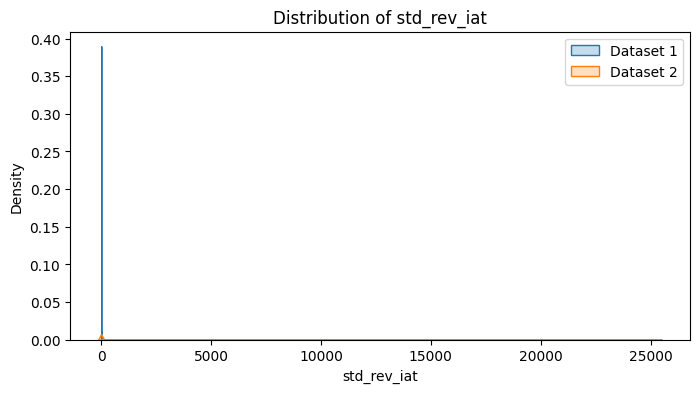

std_rev_iat - KS Test: Stat=0.984, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


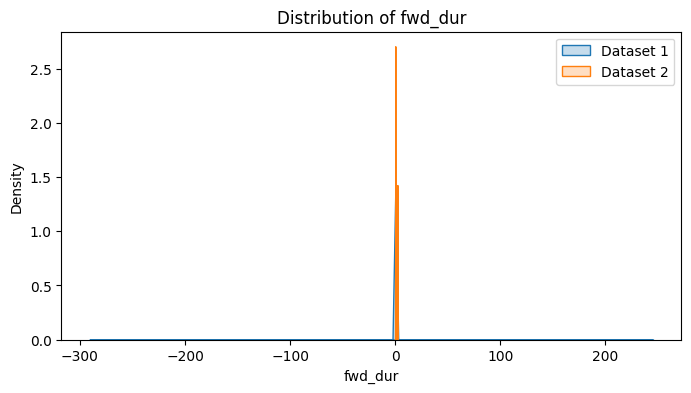

fwd_dur - KS Test: Stat=0.885, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


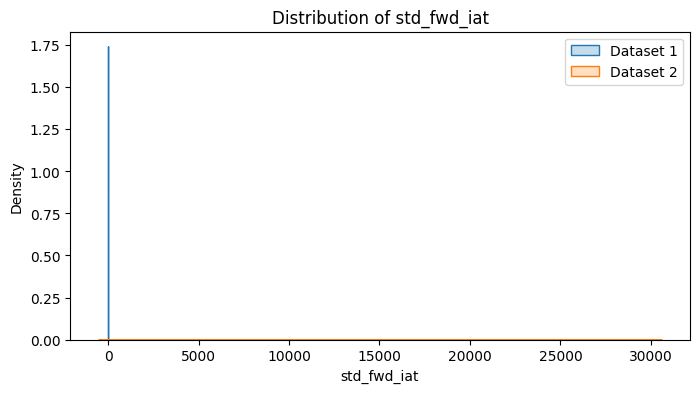

std_fwd_iat - KS Test: Stat=0.958, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


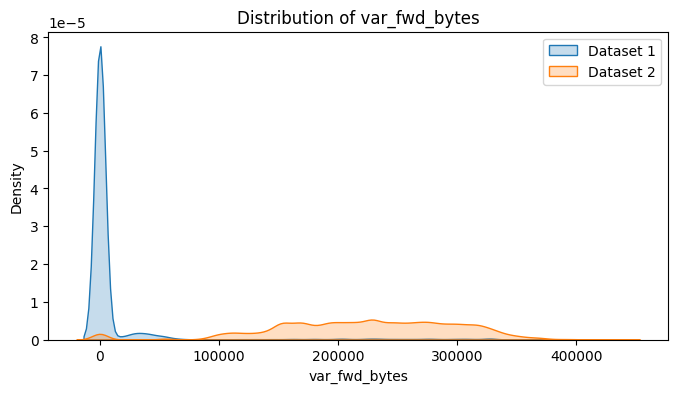

var_fwd_bytes - KS Test: Stat=0.927, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


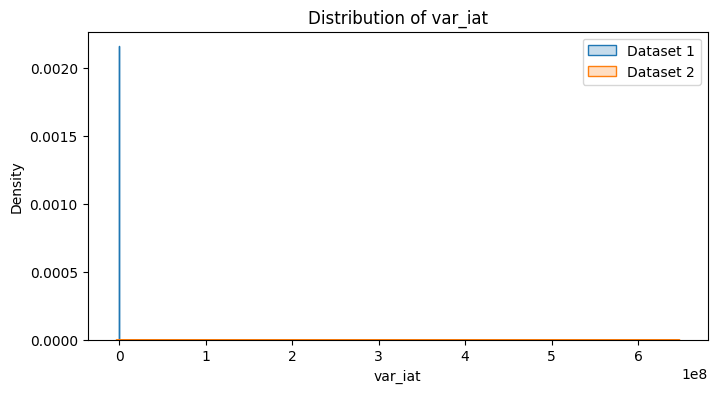

var_iat - KS Test: Stat=0.978, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


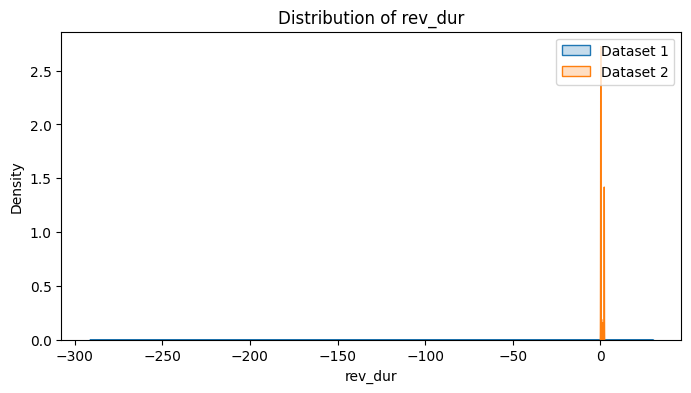

rev_dur - KS Test: Stat=0.869, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


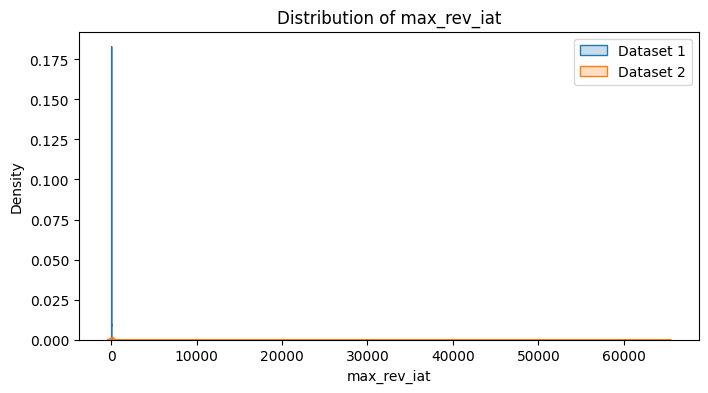

max_rev_iat - KS Test: Stat=0.996, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


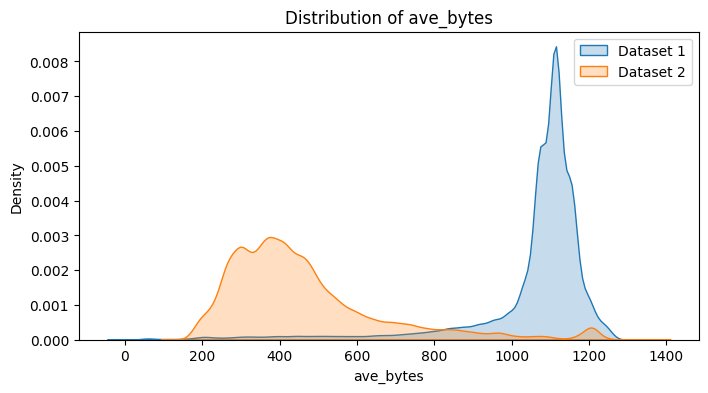

ave_bytes - KS Test: Stat=0.851, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


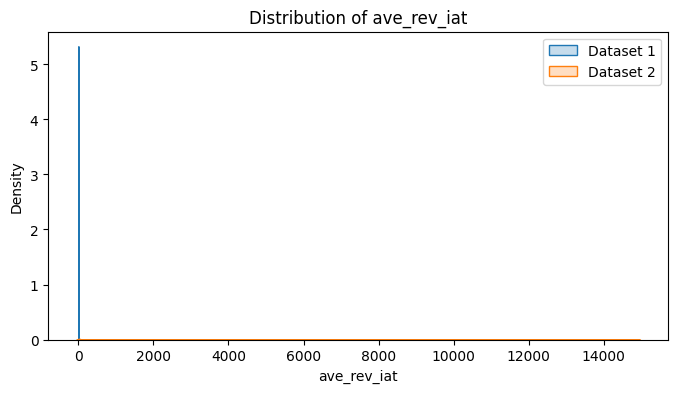

ave_rev_iat - KS Test: Stat=0.976, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


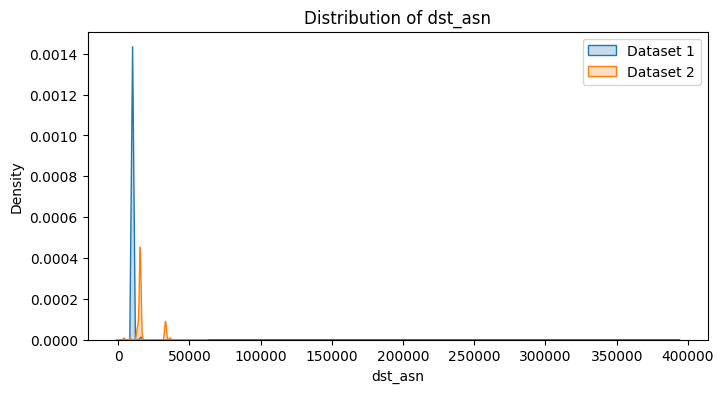

dst_asn - KS Test: Stat=0.819, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


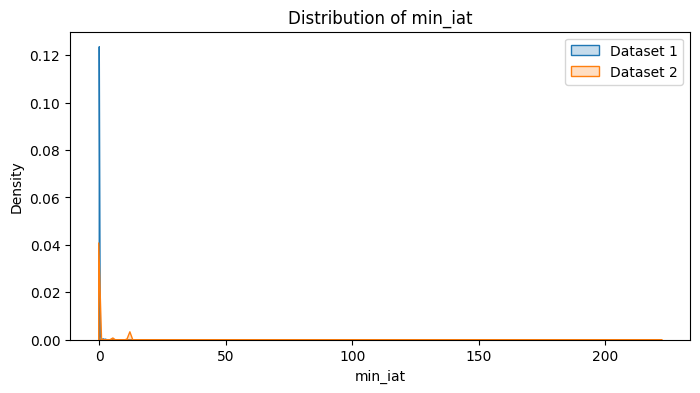

min_iat - KS Test: Stat=0.990, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


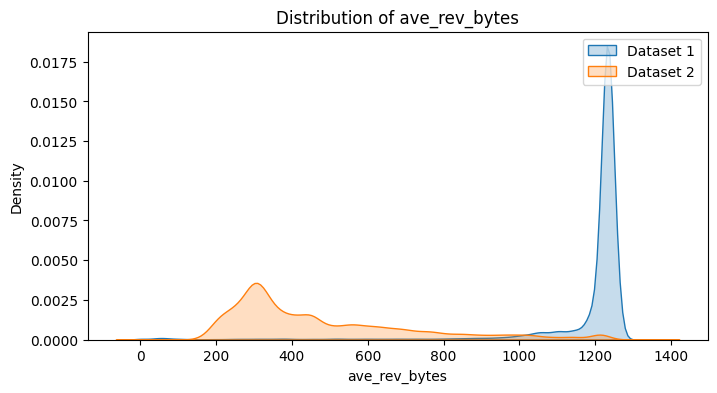

ave_rev_bytes - KS Test: Stat=0.882, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


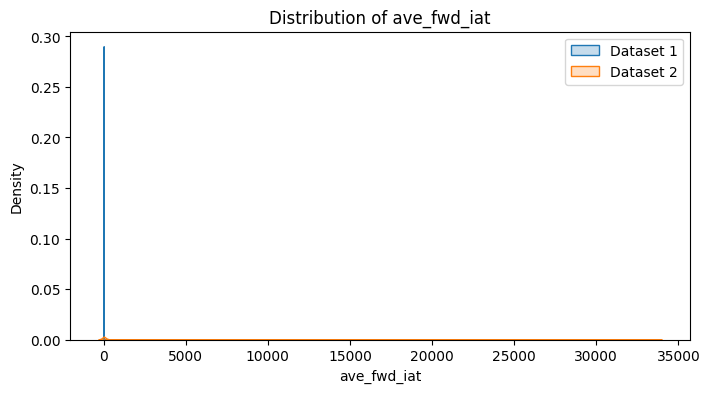

ave_fwd_iat - KS Test: Stat=0.959, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


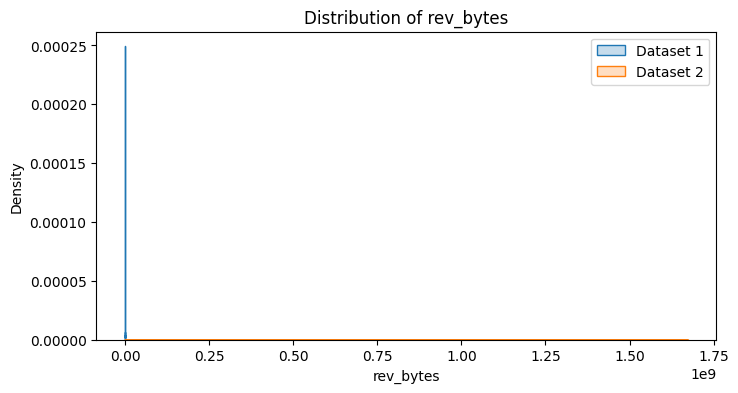

rev_bytes - KS Test: Stat=0.798, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


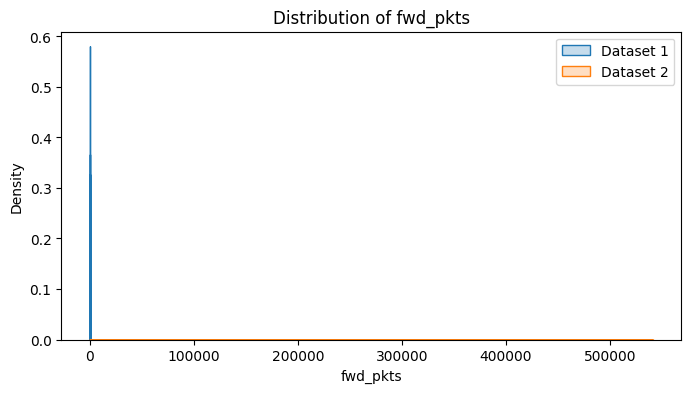

fwd_pkts - KS Test: Stat=0.796, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


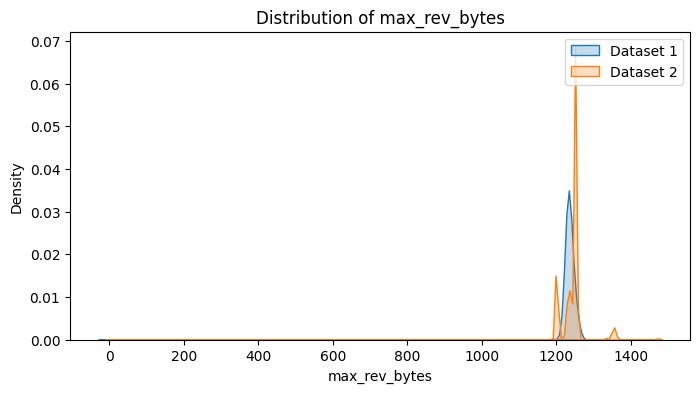

max_rev_bytes - KS Test: Stat=0.506, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


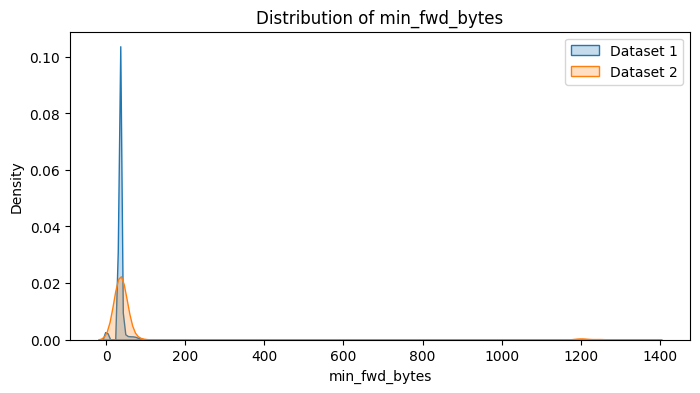

min_fwd_bytes - KS Test: Stat=0.601, P-Value=0.000


C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True)
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\2963717434.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True)


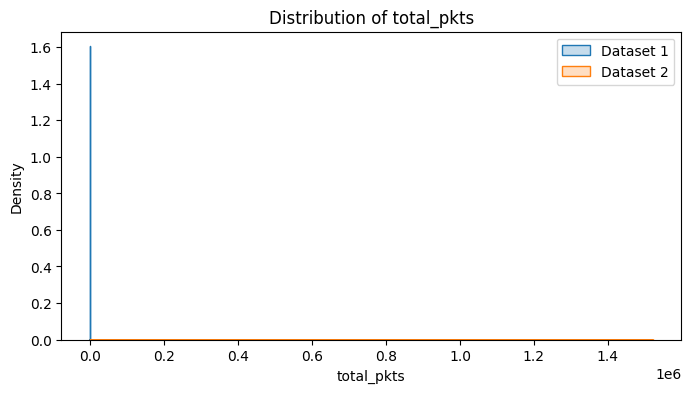

total_pkts - KS Test: Stat=0.586, P-Value=0.000

Number of overlapping rows: 0
total_bytes - JS Divergence: 0.826
ave_fwd_bytes - JS Divergence: 0.702
min_rev_bytes - JS Divergence: 0.712
var_fwd_iat - JS Divergence: 0.126
max_bytes - JS Divergence: 0.824
min_fwd_iat - JS Divergence: 0.010
var_rev_bytes - JS Divergence: 0.682
std_iat - JS Divergence: 0.199
max_fwd_iat - JS Divergence: 0.214
rev_pkts - JS Divergence: 0.829
std_rev_bytes - JS Divergence: 0.683
max_fwd_bytes - JS Divergence: 0.819
ave_iat - JS Divergence: 0.172
std_fwd_bytes - JS Divergence: 0.740
ratio - JS Divergence: 0.420
min_bytes - JS Divergence: 0.786
flow_byte_rate - JS Divergence: 0.331
quic_ver - JS Divergence: 0.833
var_bytes - JS Divergence: 0.551
min_rev_iat - JS Divergence: 0.016
max_iat - JS Divergence: 0.222
fwd_bytes - JS Divergence: 0.155
var_rev_iat - JS Divergence: 0.038
dst_port - JS Divergence: 0.000
flow_pkt_rate - JS Divergence: 0.264
dur - JS Divergence: 0.250
label - JS Divergence: 0.000
std_byte

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon

# Load datasets
df1 = pd.read_csv("benign.csv")  # Simulated dataset
df1.dropna(inplace=True)
df2 = pd.read_csv("reduced_cesnet.csv")  # External dataset
df2.dropna(inplace=True)

# 1. Check for feature compatibility
common_cols = list(set(df1.columns) & set(df2.columns))
df1, df2 = df1[common_cols], df2[common_cols]

print("Common columns:", common_cols)

# 2. Compare summary statistics
print("\nDataset 1 summary:")
print(df1.describe())

print("\nDataset 2 summary:")
print(df2.describe())

# 3. Compare distributions
for col in common_cols:
    if df1[col].dtype in ['float64', 'int64']:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(df1[col], label='Dataset 1', shade=True)
        sns.kdeplot(df2[col], label='Dataset 2', shade=True)
        plt.title(f"Distribution of {col}")
        plt.legend()
        plt.show()
        
        # KS Test
        ks_stat, ks_p = ks_2samp(df1[col].dropna(), df2[col].dropna())
        print(f"{col} - KS Test: Stat={ks_stat:.3f}, P-Value={ks_p:.3f}")
    
    elif df1[col].dtype == 'object':  # Categorical
        contingency_table = pd.crosstab(df1[col], df2[col])
        chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table)
        print(f"{col} - Chi-Square Test: Stat={chi2_stat:.3f}, P-Value={chi2_p:.3f}")

# 4. Check for duplicates
overlap = df1.merge(df2, how='inner')
print("\nNumber of overlapping rows:", len(overlap))

# 5. Measure Jensen-Shannon Divergence
js_divergences = {}
for col in common_cols:
    if df1[col].dtype in ['float64', 'int64']:
        hist1, _ = np.histogram(df1[col].dropna(), bins=50, density=True)
        hist2, _ = np.histogram(df2[col].dropna(), bins=50, density=True)
        js_div = jensenshannon(hist1, hist2)
        js_divergences[col] = js_div
        print(f"{col} - JS Divergence: {js_div:.3f}")

# If JS Divergence is low (e.g., < 0.1), datasets are similar

Common columns: ['total_bytes', 'ave_fwd_bytes', 'min_rev_bytes', 'var_fwd_iat', 'max_bytes', 'min_fwd_iat', 'var_rev_bytes', 'std_iat', 'max_fwd_iat', 'rev_pkts', 'std_rev_bytes', 'max_fwd_bytes', 'ave_iat', 'std_fwd_bytes', 'ratio', 'min_bytes', 'flow_byte_rate', 'quic_ver', 'var_bytes', 'min_rev_iat', 'max_iat', 'fwd_bytes', 'var_rev_iat', 'dst_port', 'flow_pkt_rate', 'dur', 'label', 'std_bytes', 'std_rev_iat', 'fwd_dur', 'std_fwd_iat', 'var_fwd_bytes', 'var_iat', 'rev_dur', 'max_rev_iat', 'ave_bytes', 'ave_rev_iat', 'dst_asn', 'min_iat', 'ave_rev_bytes', 'ave_fwd_iat', 'rev_bytes', 'fwd_pkts', 'max_rev_bytes', 'min_fwd_bytes', 'total_pkts']

Dataset 1 summary:
        total_bytes  ave_fwd_bytes  min_rev_bytes   var_fwd_iat  \
count  164720.00000  164720.000000  164720.000000  1.647200e+05   
mean    31430.45312      59.595099     978.326736  9.316219e-01   
std      5650.01728      93.183972     458.027598  3.627466e+01   
min         0.00000       0.000000       0.000000  0.000000

C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\781786310.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True, ax=axes[i])
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\781786310.py:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True, ax=axes[i])
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\781786310.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True, ax=axes[i])
C:\Users\carlo.alamani\AppData\Local\Temp\ipykernel_14064\781786310.py:42: FutureWarning: 

`shade` is now

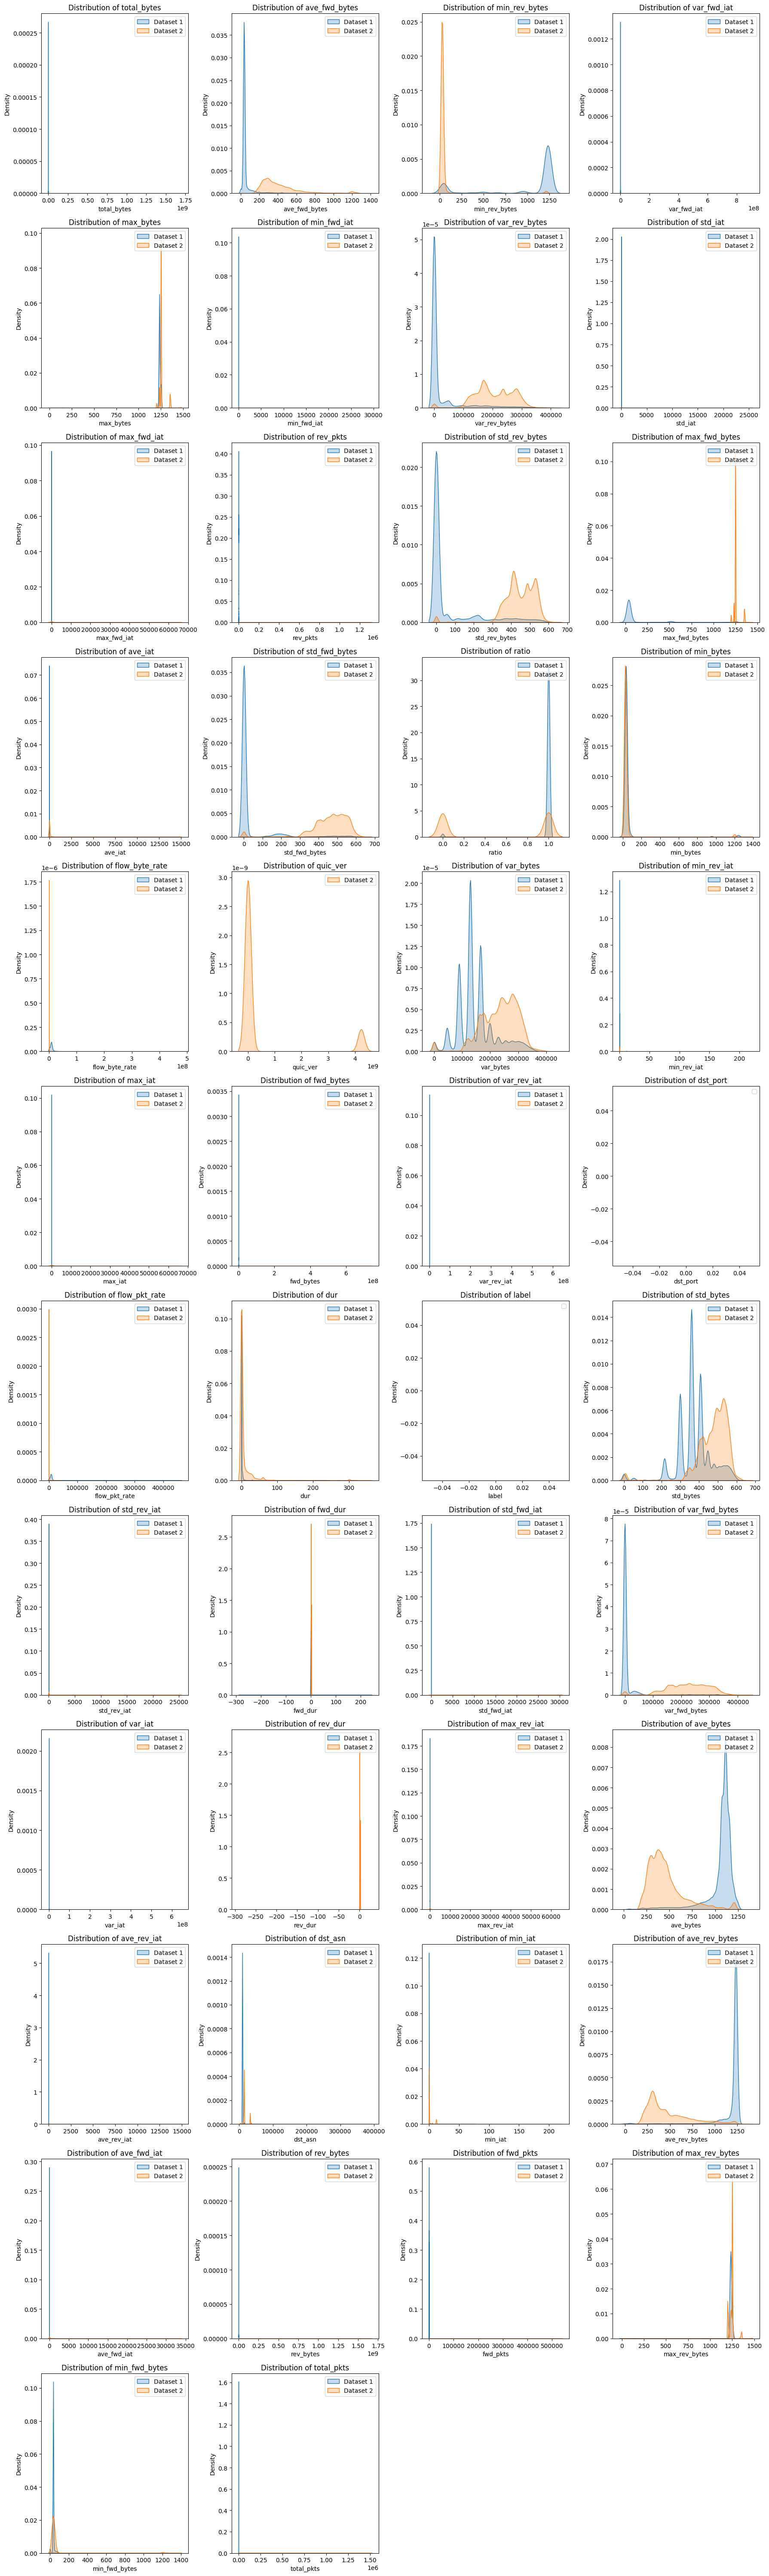

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon

# Load datasets
df1 = pd.read_csv("benign.csv")  # Simulated dataset
df1.dropna(inplace=True)
df2 = pd.read_csv("reduced_cesnet.csv")  # External dataset
df2.dropna(inplace=True)

# 1. Check for feature compatibility
common_cols = list(set(df1.columns) & set(df2.columns))
df1, df2 = df1[common_cols], df2[common_cols]

print("Common columns:", common_cols)

# 2. Compare summary statistics
print("\nDataset 1 summary:")
print(df1.describe())

print("\nDataset 2 summary:")
print(df2.describe())

# 3. Single Large Plot for Distribution Comparison (only when both datasets have data)
num_features = [
    col for col in common_cols 
    if df1[col].dtype in ['float64', 'int64'] and df1[col].dropna().size > 0 and df2[col].dropna().size > 0
]
num_plots = len(num_features)

if num_plots > 0:
    # Set up the figure with subplots
    rows = (num_plots // 4) + (num_plots % 4 > 0)  # Arrange in rows of 3 columns
    fig, axes = plt.subplots(rows, 4, figsize=(18, rows * 5))  # Adjust figure size dynamically
    axes = axes.flatten()  # Flatten to easily iterate

    for i, col in enumerate(num_features):
        sns.kdeplot(df1[col], label='Dataset 1', shade=True, ax=axes[i])
        sns.kdeplot(df2[col], label='Dataset 2', shade=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].legend()

    # Hide unused subplots if any
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
else:
    print("No features have valid data in both datasets for comparison.")
